<h1><strong>Downsampling Experiment</strong></h1>

In [1]:
import torch
import os
import h5py
import preprocess
import numpy as np
import matplotlib.pyplot as plt
from utils import SequenceDataset, plot_sample
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn, optim
from pathlib import Path
# Import the necessary classes
from score import ScoreUNet
from score import VPSDE
from score import GaussianScore
import importlib
import score
importlib.reload(score)

<module 'score' from '/home/mtemoschenko/TFE/score.py'>

<h2>Load Model</h2>

In [ ]:
checkpoint_path = "slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_310.pth"

In [73]:
import importlib
import score
importlib.reload(score)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PATH_DATA = Path('./data/processed')
# Load mask
with h5py.File(PATH_DATA / "mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32, device=device).unsqueeze(0)
    mask_cpu = mask.detach().clone().cpu()
if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")
window = 12
# Load dataset to get dimensions
testset = SequenceDataset(PATH_DATA / "test.h5", window=window, flatten=True)

channels, y_dim, x_dim = testset[0][0].shape
print(f"Channels : {channels}")

TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 5,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128,128,256],
'attention_levels' : [2],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }

Using device: cuda


RuntimeError: DataLoader worker (pid 2523985) is killed by signal: Killed. 

In [4]:
batch_size = TRAIN_CONFIG['batch_size']
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
# Initialize ScoreUNet and VPSDE
score_unet = ScoreUNet(**MODEL_CONFIG).to(device)
vpsde = VPSDE(score_unet, shape=(channels, y_dim, x_dim), eta = TRAIN_CONFIG["eta"]).to(device)
# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
vpsde.load_state_dict(checkpoint['model_state_dict'])
print(f"Model restored from {checkpoint_path}, trained until epoch {checkpoint['epoch']}")

/tmp/ipykernel_278423/3784321478.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Model restored from slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_310.pth, trained until epoch 310


<h2>Load others models</h2>

In [2]:
# Evaluate other model
from utils import ACTIVATIONS
import utils
importlib.reload(utils)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
'''
#Giddy Pond
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 48,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    #"activation": "SiLU",
    "eta": 5e-3,
    'y' : 64,
    'x' : 64
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128, 256, 512, 1024],
'attention_levels' : [4],
'hidden_blocks' : [2,3,3,3,3],
'spatial' : 2,
'channels' : 24,
'context' : 5,
'embedding' : 64}

# Bumbling Snow
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 32,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
   # "activation": "SiLU",
    "eta": 5e-3,
    'y' : 64,
    'x' : 64
}
MODEL_CONFIG = {
    'hidden_channels': [64, 128, 256, 512, 768],
    'attention_levels': [2,3,4],
    'hidden_blocks': [2, 3, 4, 3,2],
    'spatial': 2,
    'channels': 24,
    'context': 5,
    'embedding': 128
}

# Fast Silence 89 -> DateEmbedding(x=8, y=8, hidden_dim=32, num_layers=3)
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 32,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 128,
    "eta": 5e-3,
    'x' : 64,
    'y' : 64
}
MODEL_CONFIG = {
    'hidden_channels': [64, 128, 256, 512, 768],
    'attention_levels': [4],
    'hidden_blocks': [2, 3, 4, 3,2],
    'spatial': 2,
    'channels': 24,
    'context': 5,
    'embedding': 128,
    "activation": ACTIVATIONS['SiLU'],
}

# elated deluge 92 -> Construct Naive Context
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 1,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 128,
    "eta": 5e-3,
    'x' : 64,
    'y' : 64
}
MODEL_CONFIG = {
    'hidden_channels': [64, 128, 256, 512, 768],
    'attention_levels': [4],
    'hidden_blocks': [2, 3, 4, 3,2],
    'spatial': 2,
    'channels': 24,
    'context': 8,
    'embedding': 128,
    "activation": ACTIVATIONS['SiLU'],
}

# Revivded Glade 93 -> DateEmbedding() GERMAN
TRAIN_CONFIG = {
        "window" : 12,
        "epochs": 10000,
        "batch_size": 1,
        "learning_rate": 2e-4,
        "weight_decay": 1e-4,
        "scheduler": "cosine",
        "embedding": 512,
        "eta": 5e-3,
    }
MODEL_CONFIG = {
    'hidden_channels': [128,128,256,384,512],
    'attention_levels': [4],
    'hidden_blocks': [3,3,3,3,3],
    'spatial': 2,
    'channels': 24,
    'context': 5,
    'embedding': 512,
    "activation": ACTIVATIONS['SiLU'],
    'x' : 64,
    'y' : 64
}'
'''
# Glamorous Donkey 94 -> DateEmbedding() 
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 32,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 512,
    "eta": 5e-3,
    "y" : 64,
    "x" : 64
}
MODEL_CONFIG = {
    'hidden_channels': [64,128,256,512,1024],
    'attention_levels': [4],
    'hidden_blocks': [2,3,3,3,3],
    'spatial': 2,
    'channels': 24,
    'context': 5,
    'embedding': 512,
    "activation": ACTIVATIONS['SiLU'],
}
# x=8,y=8, hidden_dim=32, num_layers=3
#date_embedding_args = {'x': 8, 'y': 8, 'hidden_dim': 32, 'num_layers': 3}
date_embedding_args = {}
CONFIG = {**TRAIN_CONFIG, **MODEL_CONFIG}
path_data = 'data/processed'
#path_model = 'checkpoints/bumbling-snow-84_2nueyyzk/model_160.pth' 
#path_model = 'checkpoints/fast-silence-89_coqy9s8u/model_10.pth'
#path_model = 'checkpoints/elated-deluge-92_vwboono4/model_70.pth'
#path_model = 'checkpoints/revived-glade-93_b1ergcxy/model_130.pth'
path_model = 'checkpoints/glamorous-donkey-94_ywvadhbx/model_120.pth'
PATH_DATA = Path('./data/processed')
giddy_pond_setup = utils.load_setup(CONFIG, path_data, path_model, device, date_embedding=True, multi_gpu=True, date_embedding_args=date_embedding_args)

Using device: cuda


/home/mtemoschenko/TFE/utils.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded Date Embedding
Model restored from checkpoints/glamorous-donkey-94_ywvadhbx/model_120.pth, trained until epoch 120


In [3]:
testloader, vpsde, mask, mask_cpu = giddy_pond_setup['validloader'], giddy_pond_setup['vpsde'], giddy_pond_setup['mask'], giddy_pond_setup['mask_cpu']

<h2> A(x_(x(t)) </h2>

In [4]:

def downscale(batch, mask, patch_size, device='cpu'):
    if batch.shape[1] == 1 and batch.dim() == 5:
        #print(f"heheh : {batch.shape}")
        batch = batch.squeeze(1)
    #print(f"batch : {batch.shape}")
    B1, B2, H, W = batch.shape
    new_H, new_W = H // patch_size, W // patch_size
    
    patches = batch.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)  # (B1, B2, new_H, new_W, patch_size, patch_size)
    #print(mask.shape)
    myMask = mask[0]
    mask_patches = myMask.unfold(0, patch_size, patch_size).unfold(1, patch_size, patch_size)
    #print(patches.shape)
    #print(mask_patches.shape)
    valid_patches = patches * mask_patches.unsqueeze(0).unsqueeze(0)
    valid_counts = mask_patches.sum(dim=(-2, -1), keepdim=True)
    
    valid_counts = torch.where(valid_counts == 0, torch.tensor(1, device=device), valid_counts)
    downscaled_grid = valid_patches.sum(dim=(-2, -1)) / valid_counts.squeeze(-1).squeeze(-1)
    downscaled_mask = mask_patches.any(dim=(-2, -1))
    #print(downscaled_mask.shape)
    
    upsampled_batch = downscaled_grid.repeat_interleave(patch_size, dim=-1).repeat_interleave(patch_size, dim=-2)
    upsampled_mask = downscaled_mask.repeat_interleave(patch_size, dim=-1).repeat_interleave(patch_size, dim=-2)
    upsampled_batch = upsampled_batch * mask
    return upsampled_batch
def downscale_no_upsample(batch, mask=None, patch_size=16, device='cpu'):
    if batch.shape[1] == 1 and batch.dim() == 5:
        batch = batch.squeeze(1)
    if batch.shape[0] == 1 and batch.dim() == 5:
        batch = batch.squeeze(0)
    B1, B2, H, W = batch.shape
    new_H, new_W = H // patch_size, W // patch_size
    
    patches = batch.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)  # (B1, B2, new_H, new_W, patch_size, patch_size)
    
    if mask is not None:
        if isinstance(mask, list):
            mask = mask[0]
        mask = mask[0]
        mask_patches = mask.unfold(0, patch_size, patch_size).unfold(1, patch_size, patch_size)
        valid_patches = patches * mask_patches.unsqueeze(0).unsqueeze(0)
        valid_counts = mask_patches.sum(dim=(-2, -1), keepdim=True)
        valid_counts = torch.where(valid_counts == 0, torch.tensor(1, device=device), valid_counts)
        downscaled_grid = valid_patches.sum(dim=(-2, -1)) / valid_counts.squeeze(-1).squeeze(-1)
    else:
        # If no mask is provided, simply average all patches
        downscaled_grid = patches.mean(dim=(-2, -1))
    
    return downscaled_grid  # Shape: (B1, B2, new_H, new_W)
def upsample_to_64x64(downscaled_grid, mask=None, device='cpu'):
    """
    Upsamples a downscaled grid to 64x64 resolution.
    
    Args:
        downscaled_grid (torch.Tensor): Input tensor of shape (B1, B2, H, W)
        mask (torch.Tensor, optional): Mask to apply to the upsampled grid
        device (str): Device to use for tensor operations
        
    Returns:
        torch.Tensor: Upsampled tensor of shape (B1, B2, 64, 64)
    """
    B1, B2, H, W = downscaled_grid.shape
    
    # Calculate scale factors needed to reach 64x64
    scale_h = 64 // H
    scale_w = 64 // W
    
    # Check if we need to adjust for non-divisible dimensions
    pad_h = 64 - (H * scale_h)
    pad_w = 64 - (W * scale_w)
    
    # Upsample using repeat_interleave (nearest neighbor)
    upsampled = downscaled_grid.repeat_interleave(scale_h, dim=2).repeat_interleave(scale_w, dim=3)
    
    # If padding is needed, add it
    if pad_h > 0 or pad_w > 0:
        upsampled = torch.nn.functional.pad(upsampled, (0, pad_w, 0, pad_h))
    
    # Apply mask if provided
    if mask is not None:
        if isinstance(mask, list):
            mask = mask[0]
        # Ensure mask is 64x64
        if mask.shape != (64, 64):
            # Resize mask if needed
            mask_64x64 = torch.nn.functional.interpolate(
                mask.unsqueeze(0).unsqueeze(0).float(), 
                size=(64, 64), 
                mode='nearest'
            ).squeeze(0).squeeze(0).bool()
        else:
            mask_64x64 = mask
        
        upsampled = upsampled * mask_64x64.to(device)
    
    return upsampled

In [5]:
batch, dic = next(iter(testloader))
batch = batch.cpu()
new_tensor = torch.stack((batch,downscale(batch,mask_cpu,8)), dim=1).flatten(0,1).cpu()
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
# fig = plot_sample(new_tensor,info,mask_cpu,samples=9,step=3, unnormalize=True, path_unnorm = path_unnorm)


In [29]:
def A(x):
    #return downscale(x,mask,16)
    return downscale_no_upsample(x,mask,16)
x_star, c_star = next(iter(testloader))
x_star = x_star.to(device)
c_star = c_star['context'].to(device)
y_star = torch.normal(A(x_star), 1e-3)

info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
# fig = plot_sample(y_star.detach().cpu(),info,mask_cpu,samples=1,step=3, unnormalize=True, path_unnorm = path_unnorm)

<h1><bold>Visualization of Experience </bold> </h1>

In [30]:
x_star, dic_star = next(iter(testloader))
x_star = x_star.to(device)
c_star = utils.constructEmbedding(giddy_pond_setup['date_embedding'], dic_star).to(device)
y_star = torch.normal(A(x_star), 1e-3)
print(f"x_star : {x_star.shape}")
print(f"c_star : {c_star.shape}")
print(f"y_star : {y_star.shape}")

x_star : torch.Size([32, 24, 64, 64])
c_star : torch.Size([32, 5, 64, 64])
y_star : torch.Size([32, 24, 4, 4])


In [31]:
importlib.reload(score)
#sde = VPSDE(score.DPSGaussianScore(y_star,mask, A=A,  sde=vpsde, zeta=4.7), shape=x_star.shape).cuda()
sde = VPSDE(score.GaussianScore(y_star, mask, A=A, std=1e-3, sde=vpsde, gamma=0.01), shape=x_star.shape).cuda()

# Some params for Raw Gaussian Score
# gamme = 0.1, steps = 256, corrections = 2 with std=1e-3

In [32]:
num_samples = 1
x = sde.sample(mask,shape=(num_samples,), c=c_star, steps=256, corrections=2, tau=0.5).cpu()


  0%|                                                           | 0/256 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████| 256/256 [01:37<00:00,  2.64it/s]


Loaded lat/lon grid with shape: (64, 64)
T2m  Mean : -0.751143217086792, Var: 2.2437751293182373
U10m  Mean : 2.3047378063201904, Var: 0.9853265881538391
T2m  Mean : -0.7510344982147217, Var: 2.049807071685791
U10m  Mean : 2.3046493530273438, Var: 0.7148919701576233
T2m  Mean : -0.75089430809021, Var: 2.2076003551483154
U10m  Mean : 2.3048901557922363, Var: 1.0045644044876099
T2m  Mean : 18.196168899536133, Var: 1.9115732908248901
U10m  Mean : 4.546394348144531, Var: 1.9636805057525635
T2m  Mean : 18.19655418395996, Var: 1.654839277267456
U10m  Mean : 4.54684591293335, Var: 1.7253655195236206
T2m  Mean : 18.195951461791992, Var: 1.9803465604782104
U10m  Mean : 4.546498775482178, Var: 2.0448553562164307
T2m  Mean : 14.599125862121582, Var: 2.4175937175750732
U10m  Mean : 2.417116165161133, Var: 0.9153141379356384
T2m  Mean : 14.598823547363281, Var: 2.2556042671203613
U10m  Mean : 2.4169933795928955, Var: 0.7394727468490601
T2m  Mean : 14.59867000579834, Var: 2.408750057220459
U10m  Mea

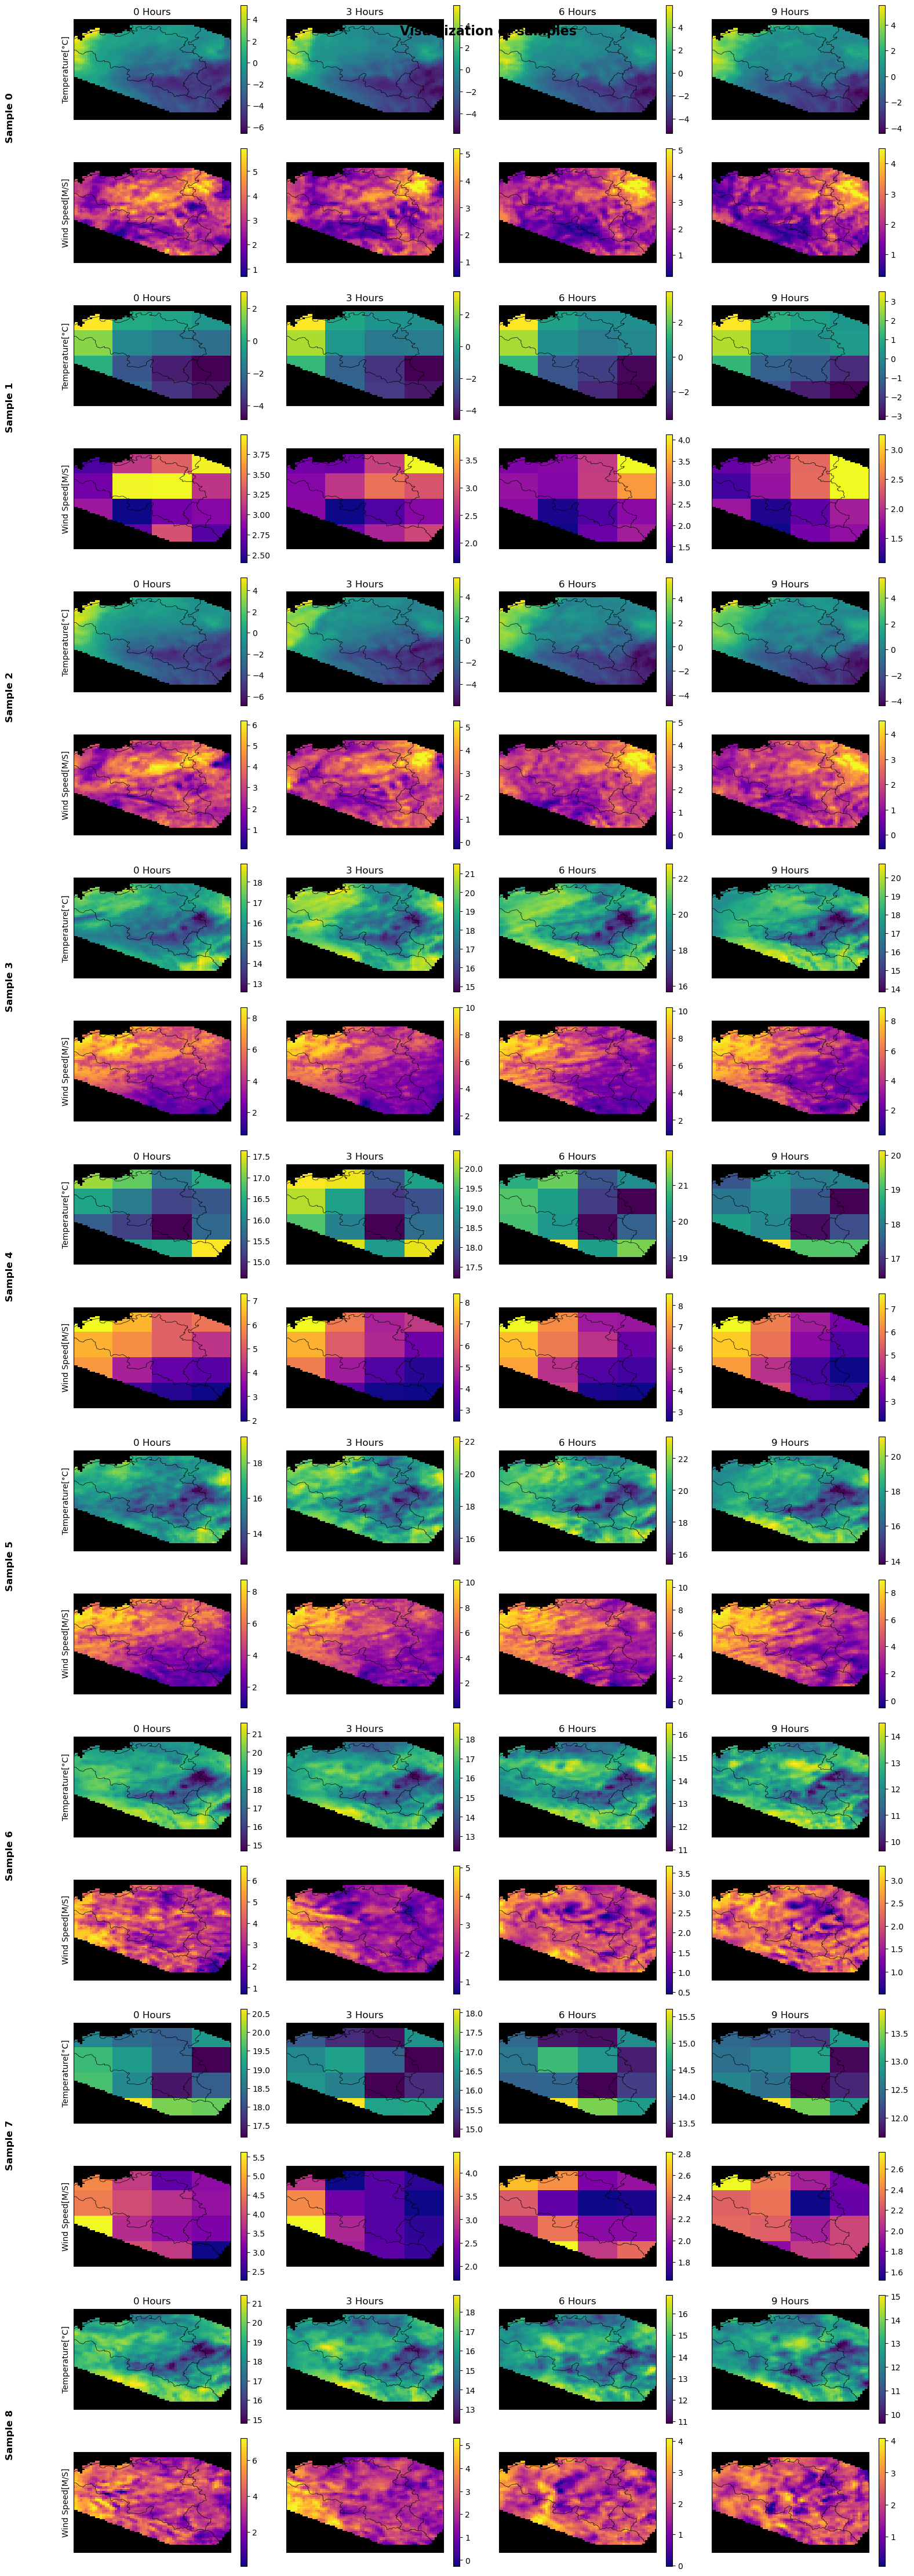

In [33]:
import utils 
importlib.reload(utils)

# If multiple batch and 1 samples squeeze(0), if multiple samples for 1 batch : squeeze(1)
x_ = x.squeeze(0)
#x_ = x.squeeze(1)


# Good parameters : zeta: 4.5, steps: 48, corrections: 3
# zeta= 4.7, steps = 64, corrections = 8, tau = 0.5
# new_tensor = torch.cat([x_star.detach().cpu(),y_star.detach().cpu(),x_.detach().cpu()])
y_star_upsample = upsample_to_64x64(y_star.cpu(), mask_cpu[0])

# 1) multiples batches and 1 sample, 2) 1 batch and multiple samples
new_tensor = torch.stack([x_star.detach().cpu(),y_star_upsample,x_.detach().cpu()], dim=1).flatten(0,1)
#new_tensor = torch.cat([x_star.detach().cpu(),y_star_upsample,x_.detach().cpu()])


path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = utils.plot_sample(new_tensor,info,mask_cpu,samples=9,step=3, unnormalize=True, path_unnorm = path_unnorm, show_borders=True)
plt.show()

<h4>Spectral Analysis of Ground Truth and generated Samples</h4>

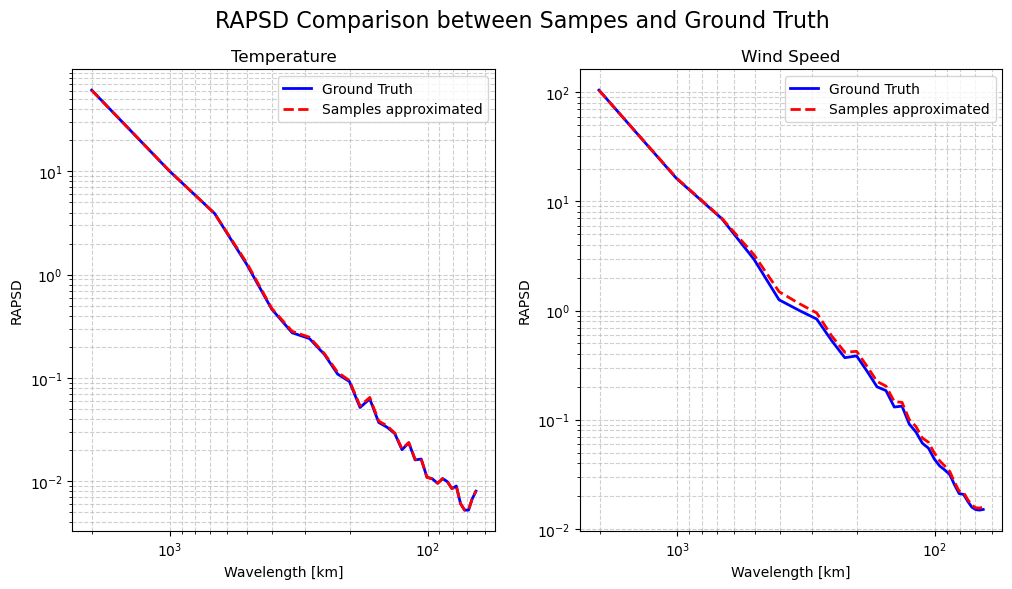

In [34]:
import metrics
importlib.reload(metrics)

wavelengths_x_star, radii,  avg_rapsd_x_star, channel_rapsds = metrics.compute_rapsd(x_star, 5)
wavelengths_x_, _, avg_rapsd_x_, _ = metrics.compute_rapsd(x_, 5)

channel_names = ["Temperature", "Wind Speed"]
title =  f"RAPSD Comparison between Sampes and Ground Truth"
figsize  = (12, 6)
fig, axes = plt.subplots(1, len(channel_names), figsize=figsize)
if len(channel_names) == 1:
    axes = np.array([axes])

mean_rapsd_x_star = np.mean(avg_rapsd_x_star.squeeze(2), axis=0)
mean_rapsd_x_ = np.mean(avg_rapsd_x_.squeeze(2), axis=0)
#mean_rapsd_y_star = np.mean(avg_rapsd_y_star.squeeze(2), axis=0)
for i, name in enumerate(channel_names):
    ax = axes[i]
    ax.loglog(wavelengths_x_star, mean_rapsd_x_star[i], 'b-', label='Ground Truth', linewidth=2)
    ax.loglog(wavelengths_x_, mean_rapsd_x_[i], 'r--', label='Samples approximated', linewidth=2)
    ax.xaxis.set_inverted(True)
    ax.set_xlabel('Wavelength [km]')
    ax.set_ylabel('RAPSD')
    ax.set_title(name)
    ax.grid(True, which="both", ls="--", alpha=0.6)
    ax.legend()


fig.suptitle(title, fontsize=16)

plt.show()

In [35]:
# Other metrics
import metrics
importlib.reload(metrics)
x_star_repeat = x_star.repeat(num_samples,1,1,1)
rmse_dic = metrics.calculate_rmse(x_.detach().cpu(), x_star_repeat.detach().cpu(), mask_cpu)
print(rmse_dic['per_variable'])

tensor([0.0681, 0.2886])


<h3>Compare A(Ground Truth) and A(samples)</h3>

RMSE A(x*) vs A(x^) : tensor([0.0017, 0.0016])


 ************** 


Loaded lat/lon grid with shape: (64, 64)
T2m  Mean : -0.7510344982147217, Var: 2.049807071685791
U10m  Mean : 2.3046493530273438, Var: 0.7148919701576233
T2m  Mean : -0.7512657642364502, Var: 2.048759937286377
U10m  Mean : 2.3052070140838623, Var: 0.7150843739509583
T2m  Mean : 18.19655418395996, Var: 1.654839277267456
U10m  Mean : 4.54684591293335, Var: 1.7253655195236206
T2m  Mean : 18.19646453857422, Var: 1.6583038568496704
U10m  Mean : 4.546228408813477, Var: 1.725053310394287
T2m  Mean : 14.598823547363281, Var: 2.2556042671203613
U10m  Mean : 2.4169933795928955, Var: 0.7394727468490601
T2m  Mean : 14.59895133972168, Var: 2.2561097145080566
U10m  Mean : 2.417264938354492, Var: 0.7393867373466492
T2m  Mean : 7.541121482849121, Var: 1.4164890050888062
U10m  Mean : 7.4802374839782715, Var: 2.1130402088165283
T2m  Mean : 7.540310382843018, Var: 1.418025016784668
U10m  Mean : 7.480076313018799, Var: 2.1126601696014404


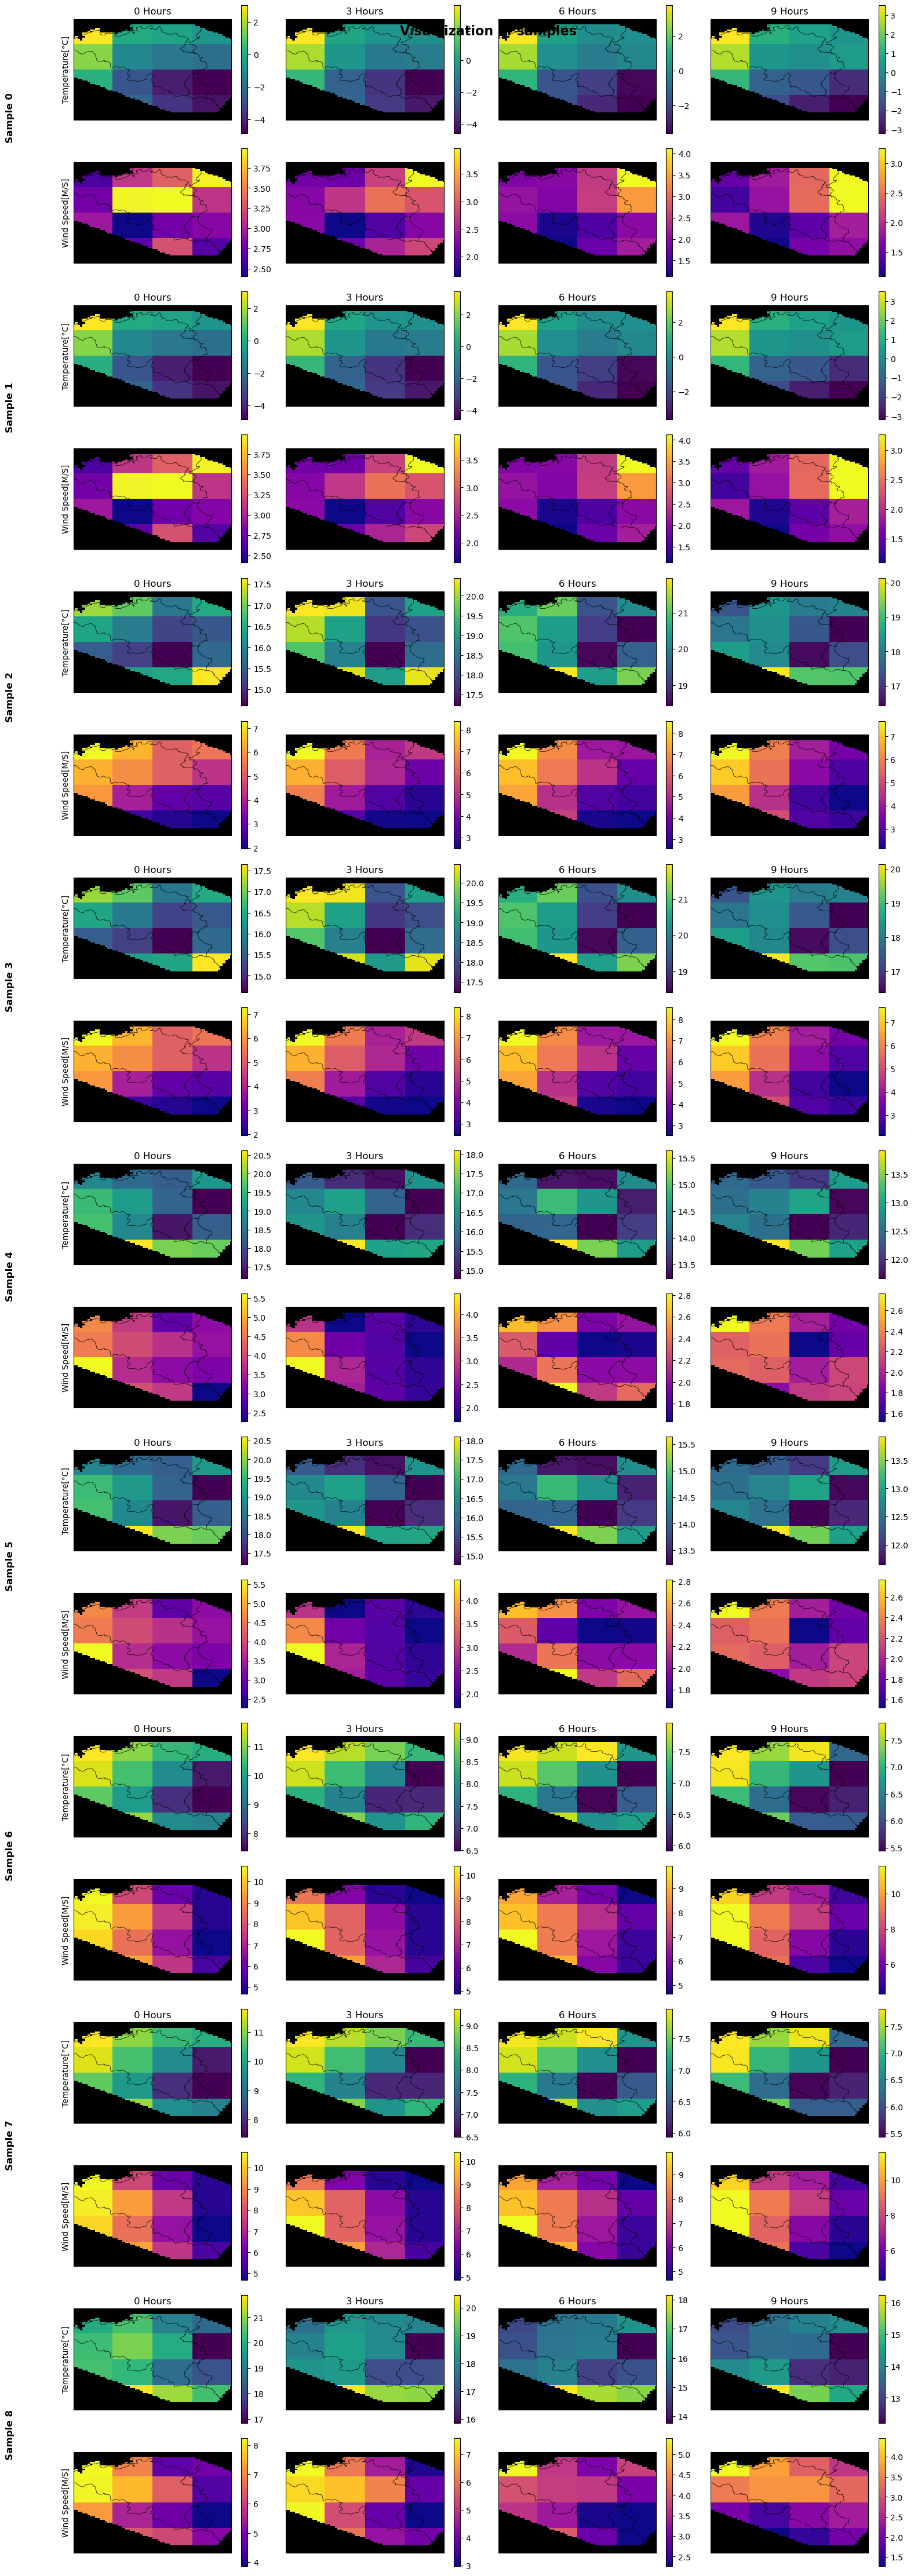

In [36]:
y_pred = torch.normal(A(x_.cuda()), 1e-3).cpu()
y_random = torch.randn(y_star.shape)
rmse_dic = metrics.calculate_rmse(y_pred.detach().cpu(), y_star.detach().cpu())
print(f"RMSE A(x*) vs A(x^) : {rmse_dic['per_variable']}")

print("\n\n ************** \n\n")

# Plot

y_star_upsample = upsample_to_64x64(y_star.cpu(), mask_cpu[0]).detach().cpu()
y_sample_upsample = upsample_to_64x64(y_pred.cpu(), mask_cpu[0]).detach().cpu()

new_tensor = torch.stack([y_star_upsample,y_sample_upsample], dim=1).flatten(0,1)
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = utils.plot_sample(new_tensor,info,mask_cpu,samples=9,step=3, unnormalize=True, path_unnorm = path_unnorm, show_borders=True)


<h3> Compare Metrics with noised data </h3>

In [119]:
print(x_star_repeat.shape)
print(c_star_repeat.shape)

torch.Size([10, 24, 64, 64])
torch.Size([10, 5, 64, 64])


In [120]:
c_star_repeat = c_star.repeat(num_samples,1,1,1)
t = torch.rand(x.shape[0]).to(device)
t[:] = 0.1
giddy_pond_setup['vpsde'].eval()
noised_x_star = giddy_pond_setup['vpsde'].forward(x_star_repeat, t, train=False).detach().cpu()

T2m  Mean : 6.627710342407227, Var: 2.98734712600708
U10m  Mean : 5.357107639312744, Var: 1.7507113218307495
T2m  Mean : 6.7142486572265625, Var: 3.3136391639709473
U10m  Mean : 5.327969074249268, Var: 1.7692570686340332
T2m  Mean : 6.6987738609313965, Var: 3.2942147254943848
U10m  Mean : 5.326298713684082, Var: 1.766196608543396
T2m  Mean : 6.706871032714844, Var: 3.300191879272461
U10m  Mean : 5.32557487487793, Var: 1.769119143486023
T2m  Mean : 6.717940330505371, Var: 3.3025877475738525
U10m  Mean : 5.3254876136779785, Var: 1.7697111368179321


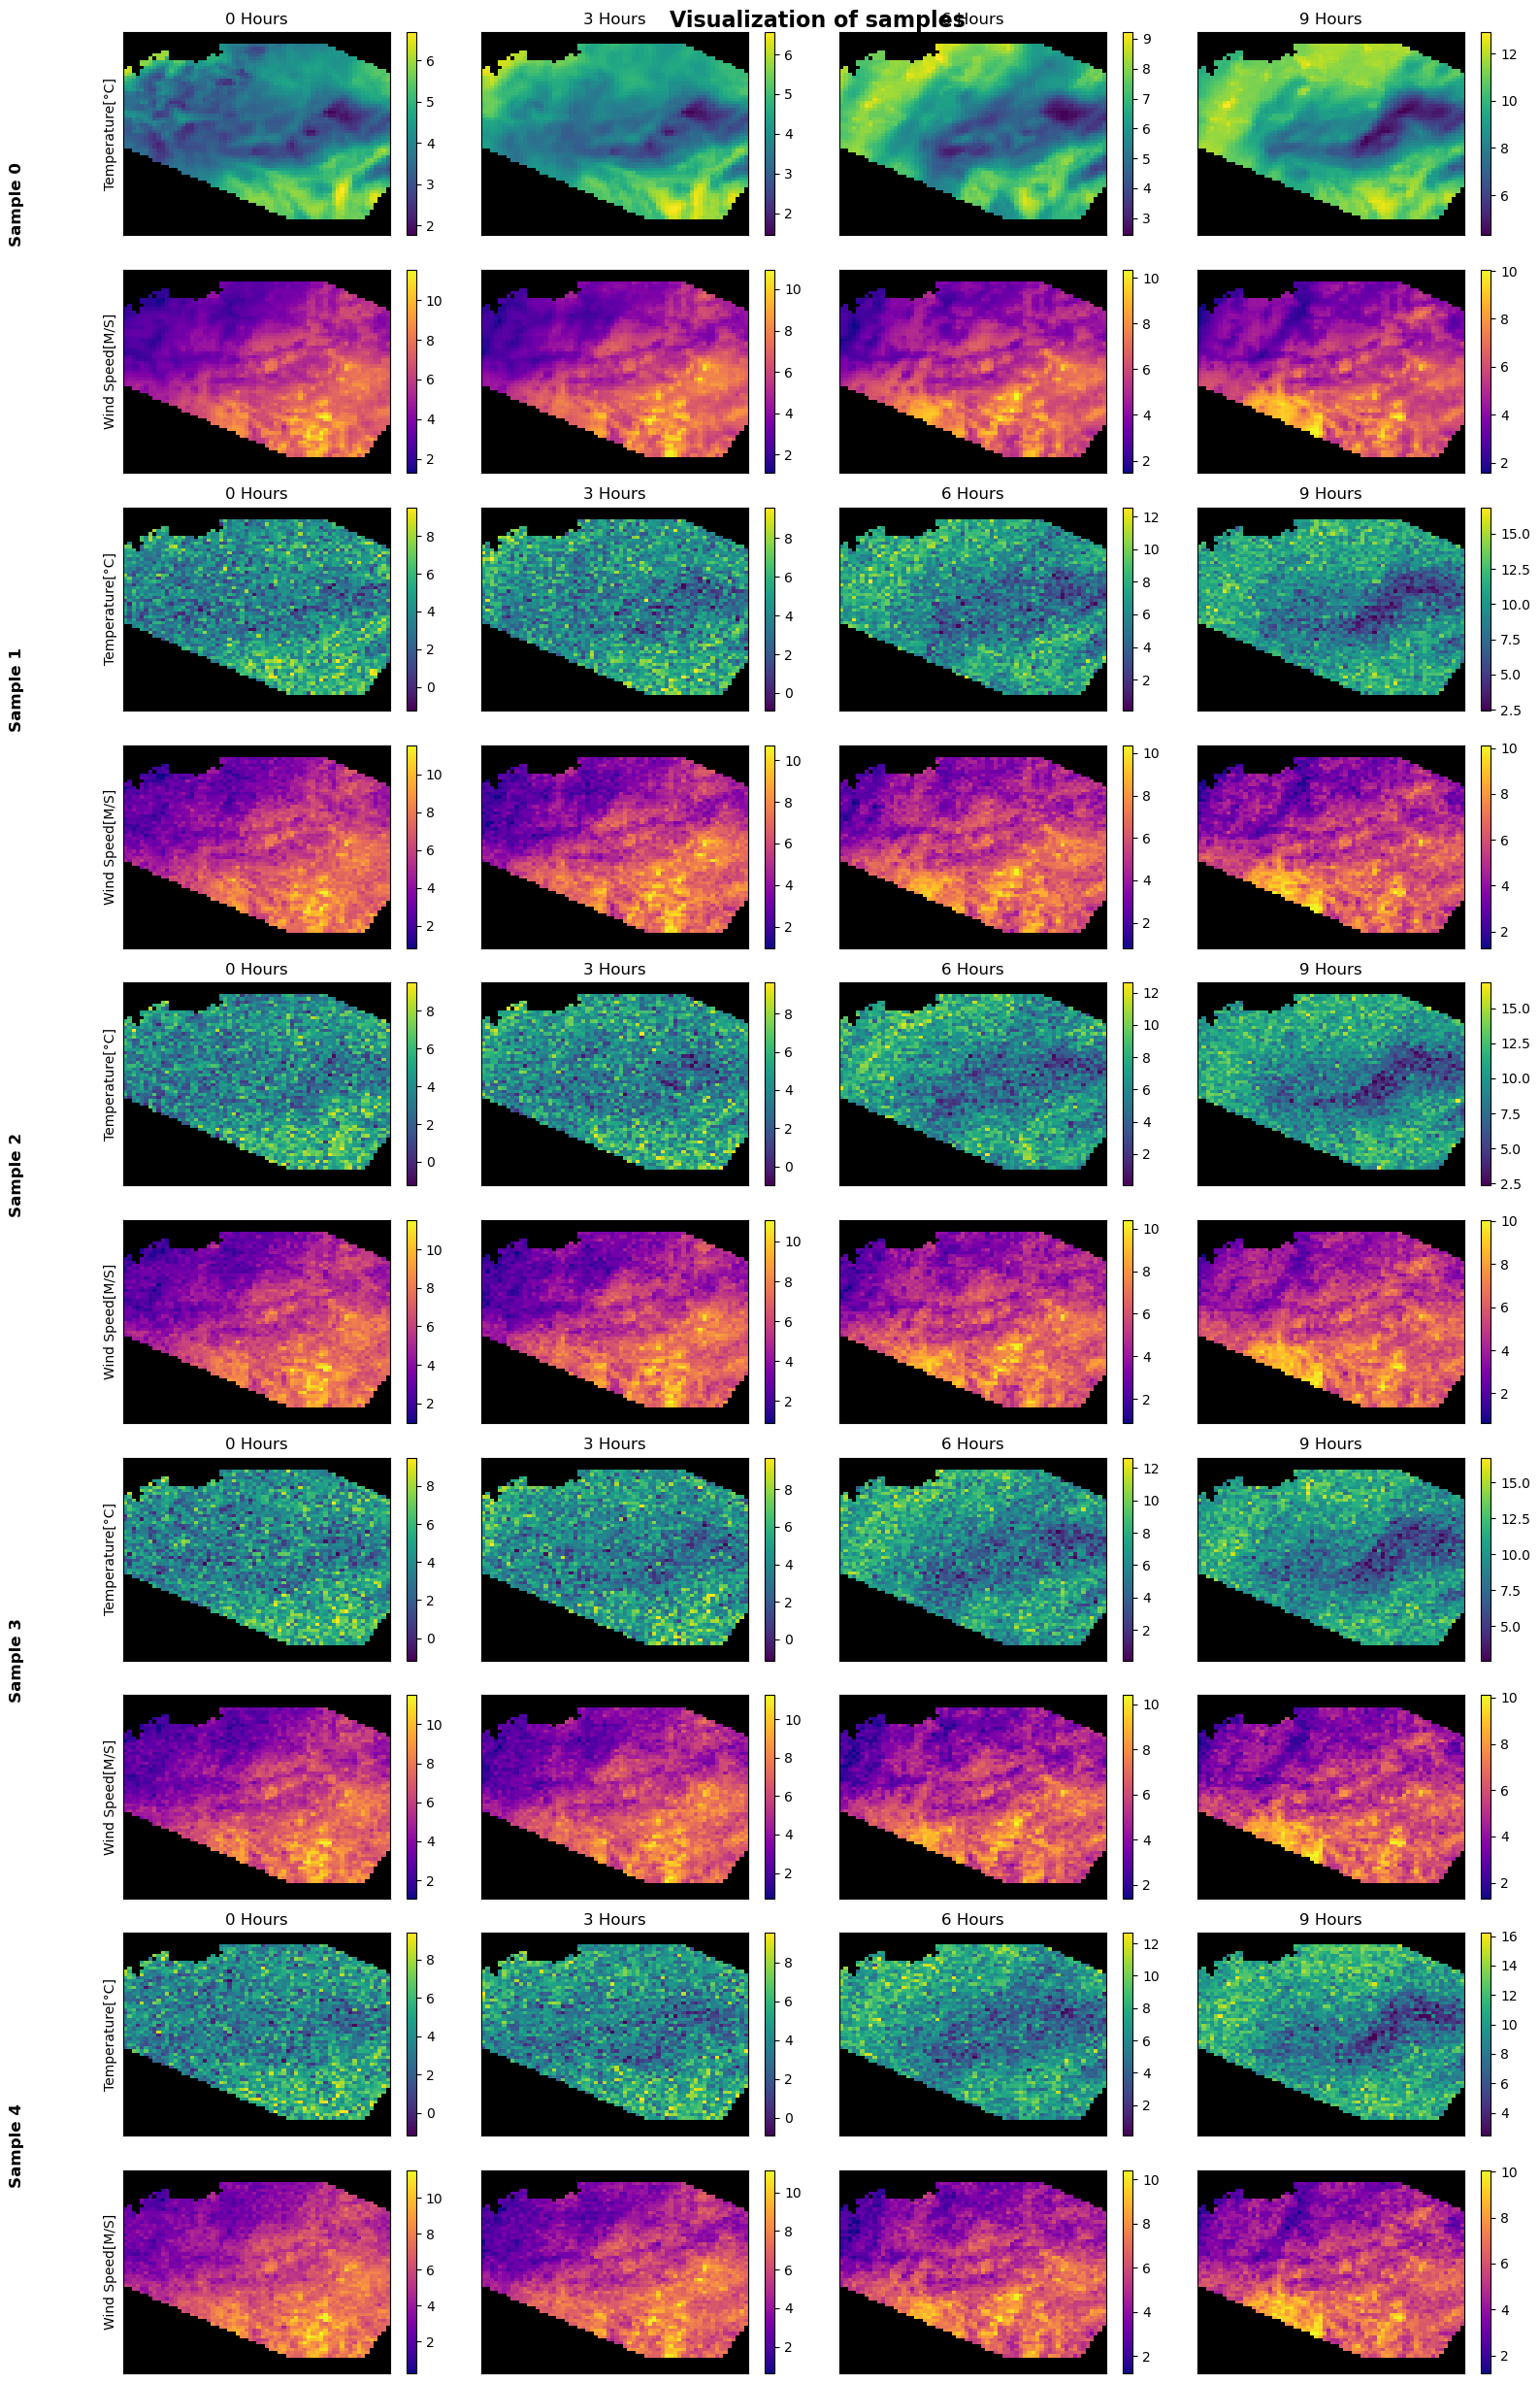

In [121]:
fig = utils.plot_sample(torch.cat([x_star.detach().cpu(),noised_x_star]),info,mask_cpu,samples=5,step=3, unnormalize=True, path_unnorm = path_unnorm, show_borders=False)

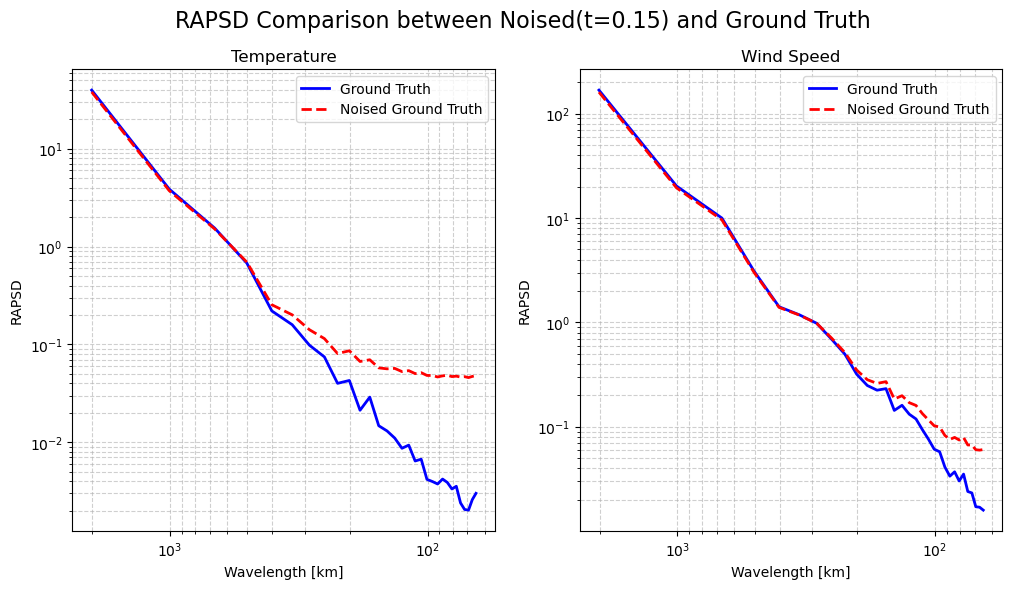

In [122]:
wavelengths_noised_x_star, _, avg_rapsd_noised_x_star, _ = metrics.compute_rapsd(noised_x_star, 5)

channel_names = ["Temperature", "Wind Speed"]
title =  f"RAPSD Comparison between Noised(t=0.15) and Ground Truth"
figsize  = (12, 6)
fig, axes = plt.subplots(1, len(channel_names), figsize=figsize)
if len(channel_names) == 1:
    axes = np.array([axes])

#mean_rapsd_x_star = np.mean(avg_rapsd_x_star.squeeze(2), axis=0)
mean_rapsd_noised_x_star = np.mean(avg_rapsd_noised_x_star.squeeze(2), axis=0)
#mean_rapsd_y_star = np.mean(avg_rapsd_y_star.squeeze(2), axis=0)
for i, name in enumerate(channel_names):
    ax = axes[i]
    ax.loglog(wavelengths_x_star, avg_rapsd_x_star.squeeze(2)[0][i], 'b-', label='Ground Truth', linewidth=2)
    ax.loglog(wavelengths_noised_x_star, mean_rapsd_noised_x_star[i], 'r--', label='Noised Ground Truth', linewidth=2)
    ax.xaxis.set_inverted(True)
    ax.set_xlabel('Wavelength [km]')
    ax.set_ylabel('RAPSD')
    ax.set_title(name)
    ax.grid(True, which="both", ls="--", alpha=0.6)
    ax.legend()

# Add overall figure title
fig.suptitle(title, fontsize=16)
# Add space for the title

plt.show()

In [123]:
import metrics
importlib.reload(metrics)
rmse = metrics.calculate_rmse(noised_x_star.detach().cpu(), x_star_repeat.detach().cpu(), mask_cpu)
variance = metrics.calculate_sample_variance(noised_x_star.detach().cpu(), mask_cpu)
print(rmse)
print(variance)


hello
torch.Size([2, 12, 64, 64])
{'per_variable': tensor([0.2109, 0.2114]), 'ensemble_rmse': tensor([0.0682, 0.0701])}
tensor([0.0398, 0.0398])
